In [1]:
import cv2
import numpy as np

def detect_and_match_features(images):
    """
    Détecte des points d'intérêt SIFT sur chaque image et trouve les correspondances entre images.
    Retourne une liste de correspondances globales: chaque élément est (i, j, point_i, point_j),
    où i et j sont les indices des deux images correspondantes, et point_i, point_j sont les coordonnées correspondantes.
    """
    # Création de l'objet détecteur SIFT
    sift = cv2.SIFT_create(5000)
    
    # Détection des points clés et calcul des descripteurs pour chaque image
    keypoints = []
    descriptors = []
    for img in images:
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        kp, desc = sift.detectAndCompute(gray, None)
        keypoints.append(kp)
        descriptors.append(desc)
    
    # Appariement des descripteurs entre chaque paire d'images
    bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=False)  # matcher pour descripteurs SIFT (L2)
    all_matches = []  # liste de toutes les correspondances (i, j, pt_i, pt_j)
    num_images = len(images)
    for i in range(num_images):
        for j in range(i+1, num_images):
            if descriptors[i] is None or descriptors[j] is None:
                continue  # passe si l'une des images n'a pas de descripteurs
            # Trouve les deux meilleurs matches pour chaque descripteur de i contre ceux de j
            matches = bf.knnMatch(descriptors[i], descriptors[j], k=2)
            good_matches = []
            # Filtre de Lowe: on conserve le match si le ratio distance est < 0.75
            for m, n in matches:
                if m.distance < 0.75 * n.distance:
                    good_matches.append(m)
            # Si suffisamment de correspondances, on les enregistre
            if len(good_matches) >= 4:
                for m in good_matches:
                    pt_i = keypoints[i][m.queryIdx].pt  # coordonnée du point dans l'image i
                    pt_j = keypoints[j][m.trainIdx].pt  # coordonnée correspondante dans l'image j
                    # On stocke les points correspondants sous forme d'arrays numpy (x, y)
                    all_matches.append((i, j, np.array(pt_i, dtype=float), np.array(pt_j, dtype=float)))
    return all_matches

# Exemple d'utilisation (en supposant une liste d'images déjà chargées):
# images = [cv2.imread(path) for path in image_paths]
# correspondences = detect_and_match_features(images)


In [2]:
from scipy.optimize import least_squares

def optimize_affine_global(correspondences, num_images):
    """
    Optimise globalement les transformations affines des images en minimisant l'erreur de reprojection sur toutes les correspondances.
    La première image (index 0) est fixée comme référence (transformée identité) pour définir le repère global.
    Retourne une liste de matrices affines 2x3 (numpy.ndarray) de longueur num_images.
    """
    # Initialisation des paramètres: 6 paramètres par image (sauf la première fixée à l'identité)
    # Paramètres initiaux : identité pour toutes les images (affine = [[1,0,0],[0,1,0]])
    # On n'optimise pas les 6 premiers paramètres (image 0), on optimise les autres.
    # On construit le vecteur initial des paramètres (pour images 1 à N-1)
    init_params = []
    for img_index in range(1, num_images):
        init_params.extend([1.0, 0.0, 0.0, 0.0, 1.0, 0.0])  # a, b, tx, c, d, ty pour une matrice affine 2x3
    init_params = np.array(init_params, dtype=float)
    
    # Fonction de coût calculant les résidus (différences) pour toutes les correspondances
    def residuals_affine(params):
        residuals = []
        # Reconstruit les matrices affines pour chaque image à partir du vecteur de paramètres
        # La première image (index 0) est identité: A0 = [[1,0,0],[0,1,0]]
        # Pour chaque autre image k, extrait ses 6 paramètres optimisés
        affine_matrices = [None] * num_images
        affine_matrices[0] = np.array([[1.0, 0.0, 0.0],   # Identité pour image 0
                                       [0.0, 1.0, 0.0]])
        for k in range(1, num_images):
            # paramètres de l'image k dans le vecteur params
            a, b, tx, c, d, ty = params[(k-1)*6 : (k-1)*6 + 6]
            affine_matrices[k] = np.array([[a, b, tx],
                                           [c, d, ty]])
        # Calcul des erreurs de chaque correspondance
        for (i, j, pt_i, pt_j) in correspondences:
            # Coordonnées homogènes du point (ajout de 1)
            x_i, y_i = pt_i
            x_j, y_j = pt_j
            # Transformation affine du point dans chaque image
            if i == 0:
                # transformation de l'image i (identité si i=0)
                x_i_trans, y_i_trans = x_i, y_i
            else:
                A_i = affine_matrices[i]
                x_i_trans = A_i[0,0]*x_i + A_i[0,1]*y_i + A_i[0,2]
                y_i_trans = A_i[1,0]*x_i + A_i[1,1]*y_i + A_i[1,2]
            if j == 0:
                x_j_trans, y_j_trans = x_j, y_j
            else:
                A_j = affine_matrices[j]
                x_j_trans = A_j[0,0]*x_j + A_j[0,1]*y_j + A_j[0,2]
                y_j_trans = A_j[1,0]*x_j + A_j[1,1]*y_j + A_j[1,2]
            # Différence entre les points transformés (erreur de correspondance)
            residuals.append(x_i_trans - x_j_trans)
            residuals.append(y_i_trans - y_j_trans)
        return np.array(residuals, dtype=float)
    
    # Optimisation par moindres carrés (Levenberg-Marquardt)
    result = least_squares(residuals_affine, init_params, method='lm')
    
    # Construction de la liste finale des matrices affines optimisées (incluant l'identité pour la première image)
    optimized_params = result.x
    affine_matrices = []
    # Image 0: identité
    affine_matrices.append(np.array([[1.0, 0.0, 0.0],
                                     [0.0, 1.0, 0.0]]))
    # Autres images: paramètres optimisés
    for k in range(1, num_images):
        a, b, tx, c, d, ty = optimized_params[(k-1)*6 : (k-1)*6 + 6]
        A_k = np.array([[a, b, tx],
                        [c, d, ty]])
        affine_matrices.append(A_k)
    return affine_matrices

# Exemple d'utilisation:
# affine_transforms = optimize_affine_global(correspondences, num_images=len(images))


In [3]:
def optimize_projective_global(correspondences, affine_matrices):
    """
    Optimise globalement les homographies (transformations projectives 3x3) en utilisant les résultats affines comme initialisation.
    Ajoute une contrainte de régularisation pour que chaque homographie reste proche d'une transformation rigide (peu de déformation).
    Retourne une liste de matrices homographie 3x3 (numpy.ndarray) optimisées.
    """
    num_images = len(affine_matrices)
    # Initialisation des paramètres homographie (8 par image, sauf image 0 fixée)
    init_params = []
    for k in range(1, num_images):
        # Construire homographie initiale H_k à partir de la matrice affine optimisée A_k
        A_k = affine_matrices[k]
        # Remplir les 8 paramètres: (h00, h01, h02, h10, h11, h12, h20, h21), on fixe h22 = 1
        h00, h01, h02 = A_k[0,0], A_k[0,1], A_k[0,2]
        h10, h11, h12 = A_k[1,0], A_k[1,1], A_k[1,2]
        # Paramètres de perspective initiaux (h20, h21) mis à 0 (affine n'a pas de perspective)
        h20, h21 = 0.0, 0.0
        init_params.extend([h00, h01, h02, h10, h11, h12, h20, h21])
    init_params = np.array(init_params, dtype=float)
    
    # Poids de régularisation (à ajuster selon l'importance voulue de la contrainte rigide)
    lambda_reg = 0.1  # poids global de la régularisation (faible pour ne pas dominer l'erreur de correspondance)
    # On peut aussi définir des poids spécifiques pour différents aspects de l'homographie
    weight_perspective = 1.0   # pénalisation des composantes de perspective (h20, h21)
    weight_affine_diff = 0.1   # pénalisation de l'écart par rapport à la matrice affine initiale
    
    # Sauvegarder les affines initiales pour la régularisation (sous forme 3x3 avec h22=1)
    affine_H = []
    affine_H.append(np.eye(3))  # image 0
    for k in range(1, num_images):
        A_k = affine_matrices[k]
        H_k = np.array([[A_k[0,0], A_k[0,1], A_k[0,2]],
                        [A_k[1,0], A_k[1,1], A_k[1,2]],
                        [0.0,      0.0,      1.0     ]])
        affine_H.append(H_k)
    
    def residuals_projective(params):
        residuals = []
        # Reconstruit les matrices homographie pour chaque image à partir des paramètres
        homographies = [None] * num_images
        homographies[0] = np.eye(3)  # référence fixée
        for k in range(1, num_images):
            # Extraire les 8 params de l'image k
            base_index = (k-1)*8
            h00, h01, h02, h10, h11, h12, h20, h21 = params[base_index: base_index+8]
            H_k = np.array([[h00, h01, h02],
                            [h10, h11, h12],
                            [h20, h21, 1.0 ]])  # h22 = 1
            homographies[k] = H_k
        # Erreur de reprojection pour chaque correspondance
        for (i, j, pt_i, pt_j) in correspondences:
            # Point en coordonnées homogènes
            x_i, y_i = pt_i
            x_j, y_j = pt_j
            # Transformation projective du point i
            H_i = homographies[i]
            H_j = homographies[j]
            # Appliquer homographie: (X, Y, W) = H * (x, y, 1)
            # Puis coordonnées transformées = (X/W, Y/W)
            Xi = H_i[0,0]*x_i + H_i[0,1]*y_i + H_i[0,2]
            Yi = H_i[1,0]*x_i + H_i[1,1]*y_i + H_i[1,2]
            Wi = H_i[2,0]*x_i + H_i[2,1]*y_i + H_i[2,2]
            Xj = H_j[0,0]*x_j + H_j[0,1]*y_j + H_j[0,2]
            Yj = H_j[1,0]*x_j + H_j[1,1]*y_j + H_j[1,2]
            Wj = H_j[2,0]*x_j + H_j[2,1]*y_j + H_j[2,2]
            # Coords transformées
            if Wi == 0 or Wj == 0:
                # Évite division par zéro (au besoin, continue ou ajoute grand résidu)
                continue
            xi_trans = Xi / Wi
            yi_trans = Yi / Wi
            xj_trans = Xj / Wj
            yj_trans = Yj / Wj
            # Ajoute l'erreur de correspondance (différences x et y)
            residuals.append(xi_trans - xj_trans)
            residuals.append(yi_trans - yj_trans)
        # Ajout du terme de régularisation (contrainte rigide) pour chaque homographie k (k>=1)
        for k in range(1, num_images):
            H_k = homographies[k]
            # Récupère l'homographie affine de référence pour k
            H_aff = affine_H[k]
            # Composantes de perspective (idéalement 0)
            p6 = H_k[2,0]  # h20
            p7 = H_k[2,1]  # h21
            residuals.append(weight_perspective * p6 * lambda_reg)
            residuals.append(weight_perspective * p7 * lambda_reg)
            # Écart par rapport à l'affine initiale sur les coefficients principaux
            # (on pénalise la différence des termes homographiques par rapport à l'affine optimisée)
            for m in range(2):  # 0 and 1 rows
                for n in range(3):  # 0,1,2 cols
                    if m == 2 and n == 2:
                        continue  # on évite le terme fixe de normalisation
            # Par simplicité, on ne pénalise explicitement que quelques aspects clés:
            # Par exemple, l'écart entre les échelles X et Y, ou l'écart des termes de rotation.
            # Ici on pénalise: (h00 vs h11) et (h01 vs h10) pour encourager rotation pure.
            a = H_k[0,0]; d = H_k[1,1]
            b = H_k[0,1]; c = H_k[1,0]
            # Pour une transformation rigide (rotation + échelle), on aurait a ~ d et b ~ -c.
            residuals.append(weight_affine_diff * (a - d) * lambda_reg)
            residuals.append(weight_affine_diff * (b + c) * lambda_reg)
        return np.array(residuals, dtype=float)
    
    # Exécute l'optimisation non-linéaire (LM)
    result = least_squares(residuals_projective, init_params, method='lm')
    
    # Reconstruit les matrices homographies optimisées complètes
    optimized_params = result.x
    homographies = []
    homographies.append(np.eye(3))  # image 0
    for k in range(1, num_images):
        base_index = (k-1)*8
        h00, h01, h02, h10, h11, h12, h20, h21 = optimized_params[base_index: base_index+8]
        H_k = np.array([[h00, h01, h02],
                        [h10, h11, h12],
                        [h20, h21, 1.0 ]])
        homographies.append(H_k)
    return homographies

# Exemple d'utilisation:
# homographies = optimize_projective_global(correspondences, affine_transforms)


In [38]:
def blend_images(images, homographies):
    """
    Assemble les images après transformation en un panorama unique.
    Utilise un calcul de coutures (seams) par graph-cut et un blending multi-bandes pour une fusion optimale.
    Retourne l'image panoramique finale.
    """
    num_images = len(images)
    # D'abord, déterminer la taille du panorama de sortie en transformant les coins des images
    # On calcule les coins de chaque image dans le repère global
    corners = []  # coins supérieurs-gauches de chaque image une fois projetée
    sizes = []    # tailles (w,h) des images transformées
    warped_images = []
    masks = []
    for idx, img in enumerate(images):
        H = homographies[idx]
        h, w = img.shape[:2]
        # Coins de l'image (en pixels) avant transformation
        corners_img = np.array([[0, 0], [w, 0], [w, h], [0, h]], dtype=float)
        # Transformation des coins pour connaître l'emprise
        # On utilise cv2.perspectiveTransform pour appliquer H aux coins
        corners_transformed = cv2.perspectiveTransform(corners_img.reshape(-1,1,2), H).reshape(-1,2)
        min_xy = corners_transformed.min(axis=0)  # min x, min y
        max_xy = corners_transformed.max(axis=0)  # max x, max y
        # Arrondir et convertir en int pour définir le rectangle englobant
        min_x, min_y = np.floor(min_xy).astype(int)
        max_x, max_y = np.ceil(max_xy).astype(int)
        # Coin supérieur gauche du ROI projeté pour cette image
        corners.append((min_x, min_y))
        # Taille de l'image projetée
        sizes.append((max_x - min_x, max_y - min_y))
        # Appliquer la transformation de l'image
        warped = cv2.warpPerspective(img, H, (max_x - min_x, max_y - min_y))
        warped_images.append(warped)
        # Masque initial (tout le contenu de l'image projetée est valable)
        mask = np.zeros((max_y - min_y, max_x - min_x), dtype=np.uint8)
        # On remplit le masque de 255 partout où il y a une projection valide (warped non noir)
        # Pour cela, on peut simplement mettre 255 sur tout le ROI de l'image projetée non nulle
        mask[warped[:, :, 0] > 0] = 255
        masks.append(mask.astype(np.uint8))
    # Fusionner les images projetées avec graph-cut pour trouver les coutures optimales
    try:
        seam_finder = cv2.detail_GraphCutSeamFinder("COST_COLOR")
    except AttributeError:
        seam_finder = None
    if seam_finder is not None:
        # Calcul des coutures optimales: ajuste les masques de chaque image
        #masks = seam_finder.find(warped_images, corners, masks)
        pass
    else:
        # Si GraphCutSeamFinder non disponible, on peut envisager d'autres méthodes (e.g. pas de modification des masques)
        pass
    # Appliquer un blender multi-bandes pour fusionner les images en douceur
    blender = cv2.detail_MultiBandBlender()
    # Déterminer les dimensions du panorama final (englobant tous les coins)
    all_corners = np.array([ [x, y] for (x,y) in corners ] + [ [corners[i][0] + sizes[i][0], corners[i][1] + sizes[i][1]] for i in range(num_images) ])
    min_x, min_y = all_corners.min(axis=0)
    max_x, max_y = all_corners.max(axis=0)
    panorama_width = max_x - min_x
    panorama_height = max_y - min_y
    blender.prepare((min_x, min_y, panorama_width, panorama_height))
    # Ajouter chaque image et son masque au blender
    for idx in range(num_images):
        # Positionner l'image dans le canevas global
        x, y = corners[idx]
        blender.feed(warped_images[idx].astype(np.int16),None,(x,y)) #masks[idx].astype(np.uint8), (x, y))

    # Effectuer le blending final
    result, result_mask = blender.blend(None, None)
    return result.astype(np.uint8)

# Exemple d'utilisation:
# panorama = blend_images(images, homographies)
# cv2.imwrite("panorama.jpg", panorama)


In [41]:

def align_images_on_canvas(images, homographies):
    """
    Applique les homographies et place les images transformées dans un canevas commun,
    sans blending, simplement en copiant les pixels transformés.
    """
    num_images = len(images)
    warped_images = []
    corners = []
    sizes = []

    # Calculer les coins de toutes les images transformées
    for idx, img in enumerate(images):
        H = homographies[idx]
        h, w = img.shape[:2]
        corners_img = np.array([[0, 0], [w, 0], [w, h], [0, h]], dtype=float)
        corners_transformed = cv2.perspectiveTransform(corners_img.reshape(-1, 1, 2), H).reshape(-1, 2)
        min_xy = corners_transformed.min(axis=0)
        max_xy = corners_transformed.max(axis=0)
        min_x, min_y = np.floor(min_xy).astype(int)
        max_x, max_y = np.ceil(max_xy).astype(int)
        corners.append((min_x, min_y))
        sizes.append((max_x - min_x, max_y - min_y))
        warped = cv2.warpPerspective(img, H, (max_x - min_x, max_y - min_y))
        warped_images.append(warped)

    # Calculer la taille du canevas
    all_corners = np.array(
        [ [x, y] for (x, y) in corners ] +
        [ [corners[i][0] + sizes[i][0], corners[i][1] + sizes[i][1]] for i in range(num_images) ]
    )
    min_x, min_y = all_corners.min(axis=0)
    max_x, max_y = all_corners.max(axis=0)
    canvas_width = max_x - min_x
    canvas_height = max_y - min_y

    # Créer un canevas vide
    canvas = np.zeros((canvas_height, canvas_width, 3), dtype=np.uint8)

    # Coller chaque image à sa position
    for idx in range(num_images):
        x, y = corners[idx]
        warped = warped_images[idx]
        h, w = warped.shape[:2]
        x_offset = x - min_x
        y_offset = y - min_y
        # Superposition simple : pixels non noirs sont copiés
        mask = (warped > 0).any(axis=2)
        canvas[y_offset:y_offset+h, x_offset:x_offset+w][mask] = warped[mask]

    return canvas


In [5]:
import glob
import re

In [6]:
images=glob.glob("data\*.jpg")
iimages=sorted(images, key=lambda s:int(re.search(r'\d+',s).group()))
im0=cv2.imread(iimages[191])
im1=cv2.imread(iimages[192])
im2=cv2.imread(iimages[193])

In [25]:
images=[im0,im1]

In [26]:
correspondences = detect_and_match_features(images)

In [27]:
affine_transforms = optimize_affine_global(correspondences, num_images=len(images))

In [28]:
homographies = optimize_projective_global(correspondences, affine_transforms)

In [42]:
panorama = align_images_on_canvas(images, homographies)


In [30]:
import matplotlib.pyplot as plt

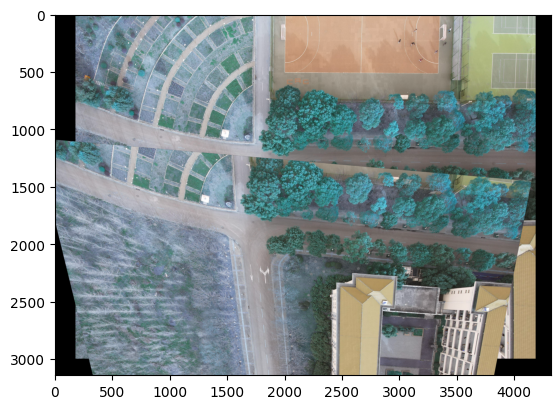

In [43]:
plt.imshow(panorama)
plt.show()

In [2]:
import glob
import cv2
import random
import re
import matplotlib.pyplot as plt
import numpy as np

In [3]:
images=glob.glob("data\*.jpg")
iimages=sorted(images, key=lambda s:int(re.search(r'\d+',s).group()))

In [6]:
im0=cv2.imread(iimages[191])
im1=cv2.imread(iimages[192])
im2=cv2.imread(iimages[193])

In [7]:
sift=cv2.SIFT_create(5000)
k1,d1= sift.detectAndCompute(im1,None)
k2,d2= sift.detectAndCompute(im2,None)

matcher= cv2.BFMatcher()
matches= matcher.knnMatch(d1,d2,k=2)
distances=[]
pts=[]
good=[]
for m,n in matches:
    if m.distance<0.75*n.distance:
        q=m.queryIdx
        t=m.trainIdx
        pos1=np.round(k1[q].pt).astype(int)
        pos2=np.round(k2[t].pt).astype(int)
        pts.append((pos1,pos2))
        dist=np.sqrt((pos1[0]-pos2[0])**2+(pos1[1]-pos2[1])**2)
        distances.append(dist)
        good.append(m)
moy_dist=np.mean(distances)
pts=np.array(pts)
print(len(good))
print(moy_dist)

382
630.4788692240855


In [8]:
best=[good[i] for i,n in enumerate(distances) if abs(moy_dist-n)<0.25*moy_dist]
print(len(best))

323


In [9]:
src=np.float32([k1[m.queryIdx].pt for m in best]).reshape(-1,1,2)
dst=np.float32([k2[m.trainIdx].pt for m in best]).reshape(-1,1,2)

H, _= cv2.findHomography(src,dst,cv2.RANSAC, 5.0)

h1,w1=im1.shape[:2]
h2,w2=im2.shape[:2]

pts_img1 = np.array([
    [0, 0],
    [w1, 0],
    [w1, h1],
    [0, h1]
], dtype=np.float32).reshape(-1, 1, 2)


proj_pts = cv2.perspectiveTransform(pts_img1, H)
all_pts = np.concatenate((proj_pts, pts_img1), axis=0).reshape(-1, 2)
[xmin, ymin] = np.floor(np.min(all_pts, axis=0)).astype(int)
[xmax, ymax] = np.ceil(np.max(all_pts, axis=0)).astype(int)

# Translation pour éviter les coordonnées négatives
tx, ty = -xmin, -ymin
T = np.array([
    [1, 0, tx],
    [0, 1, ty],
    [0, 0, 1]
])


In [10]:
canvas_w = xmax - xmin
canvas_h = ymax - ymin

offset = np.array([-xmin, -ymin], dtype=int)

translated_corners_img1 = (proj_pts + offset).astype(int)

[x_min, y_min] = np.int32(proj_pts.min(axis=0).ravel())
[x_max, y_max] = np.int32(proj_pts.max(axis=0).ravel())
translation_dist = [-x_min,-y_min]
H_translation = np.array([[1, 0, translation_dist[0]], [0, 1, translation_dist[1]], [0, 0, 1]])

In [ ]:
output_img = cv2.warpPerspective(im1, H_translation.dot(H), (x_max-x_min, y_max-y_min))
overlap1=cv2.warpPerspective(im1,H,(w2,h2))

In [ ]:
mask1 = np.ones((h1, w1), dtype=np.uint8) * 255
mask_warped = cv2.warpPerspective(mask1, H, dsize=(w2, h2))
overlap2= cv2.bitwise_and(im2,im2,mask=mask_warped)